In [1]:
from rl_envs.gym_grid_world_env import GridWorldEnv
from stable_baselines3 import DQN
from torch.utils.tensorboard import SummaryWriter
from agents.DQN_exact_book import DeepQLearningAgent
import random
import torch
from torch.utils import data
from tools.helper import *

%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

In [3]:
BATCHSIZE = 100
LEARN_RATE = 0.0015  # change to 0.001
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],
]
DISCOUNTED_FACTOR = 0.9
EPISODE_LEN = 5000

FORBIDDEN_REWARD = -10
HITWALL_REWARD = -10
TARGET_REWARD = 1

In [4]:

env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1), (1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD, render_mode="human")
agent = DeepQLearningAgent(
    input_dim=3,
    output_dim=1,
    action_space=int(env.action_n),
    lr=LEARN_RATE,
    discounted_factor=DISCOUNTED_FACTOR,
)
writer = SummaryWriter()


In [5]:
agent.policy_net.load_state_dict(torch.load("./model_saves/book-version_f_reward_-10_target_reward_1_success"))

<All keys matched successfully>

In [6]:
print_actions(agent, env, True)

[  →   →   →   ↓   ↓  ]
[  ↑   ↑   →   →   ↓  ]
[  ↑   ←   ↓   →   ↓  ]
[  ↑   →   ↺   ←   ↓  ]
[  ↑   →   ↑   ←   ←  ]


In [7]:
# env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=FORBIDDEN_REWARD, hit_wall_reward=HITWALL_REWARD, target_reward=TARGET_REWARD, render_mode="human")

obs, _ = env.reset()
total_reward = 0
routine = [obs['agent']]
for i in range(500):
    obs = tuple(obs['agent'])
    action = agent.get_action(obs)
    obs, reward, terminated, truncated, info  = env.step(action)
    # VecEnv resets automatically
    total_reward += reward
    routine.append(obs['agent'])
    if terminated or truncated:
        obs, _ = env.reset()
        print('reward: {}, distance: {}'.format(total_reward, routine))
        total_reward = 0
        routine = [obs['agent']]
        if truncated:
            print("TRUNCATE")
        else:
            print("TERMINATE")
env.close()

reward: 1, distance: [array([2, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([3, 0]), array([2, 0]), array([1, 0]), array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3]), array([1, 3]), array([1, 4]), array([2, 4]), array([3, 4]), array([4, 4]), array([4, 3]), array([4, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3]), array([1, 3]), array([1, 4]), array([2, 4]), array([3, 4]), array([4, 4]), array([4, 3]), array([4, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([2, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([3, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([0, 2]), array([0, 3]), array([1, 3]), array([1, 4]), array([2, 4]), array([3, 4]), array([4, 4]), array([4, 3]), array([4, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([2, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([3, 2]), array([3, 2])]
TERMINATE
reward: 1, distance: [array([3, 2]), ar

In [8]:
Q = agent.generate_Q_table(env.height, env.width)
print_by_dict(env, Q)

[ [2.835984945297241, 3.5175395011901855, -6.847855567932129, -6.8468828201293945, 3.158013343811035] [-6.8129377365112305, 3.8780596256256104, -6.486993312835693, 3.156038999557495, 3.517376661300659] [-5.72926664352417, 4.278237819671631, -6.125345706939697, 3.517521858215332, 3.8848774433135986] [4.838480472564697, 4.819372653961182, -5.729394912719727, 3.881342649459839, 4.276865005493164] [5.311794281005859, -5.1895880699157715, -5.185070037841797, 4.280531406402588, 4.825099468231201] ]
[ [2.5127768516540527, -6.817832946777344, 3.1574409008026123, -7.167852401733398, 2.838984966278076] [2.260751724243164, -5.732396602630615, 3.5216562747955322, 2.8401901721954346, -6.808488845825195] [-0.9845901727676392, 4.839447498321533, 3.8795156478881836, -6.814319610595703, -5.729428291320801] [5.2683491706848145, 5.312680721282959, 4.280700206756592, -5.740118026733398, 4.841115474700928] [5.93559455871582, -4.696008205413818, 4.824849605560303, 4.84185266494751, 5.315795421600342] ]
[ [2

In [9]:
V = {}
for state in Q.keys():
    V[state] = max(Q[state])
print_by_dict(env, V)


[ 3.52 3.88 4.28 4.84 5.31 ]
[ 3.16 3.52 4.84 5.31 5.94 ]
[ 2.84 2.52 10.01 5.94 6.57 ]
[ 2.51 10.01 10.02 10.01 7.30 ]
[ 2.25 9.01 10.01 9.03 8.10 ]


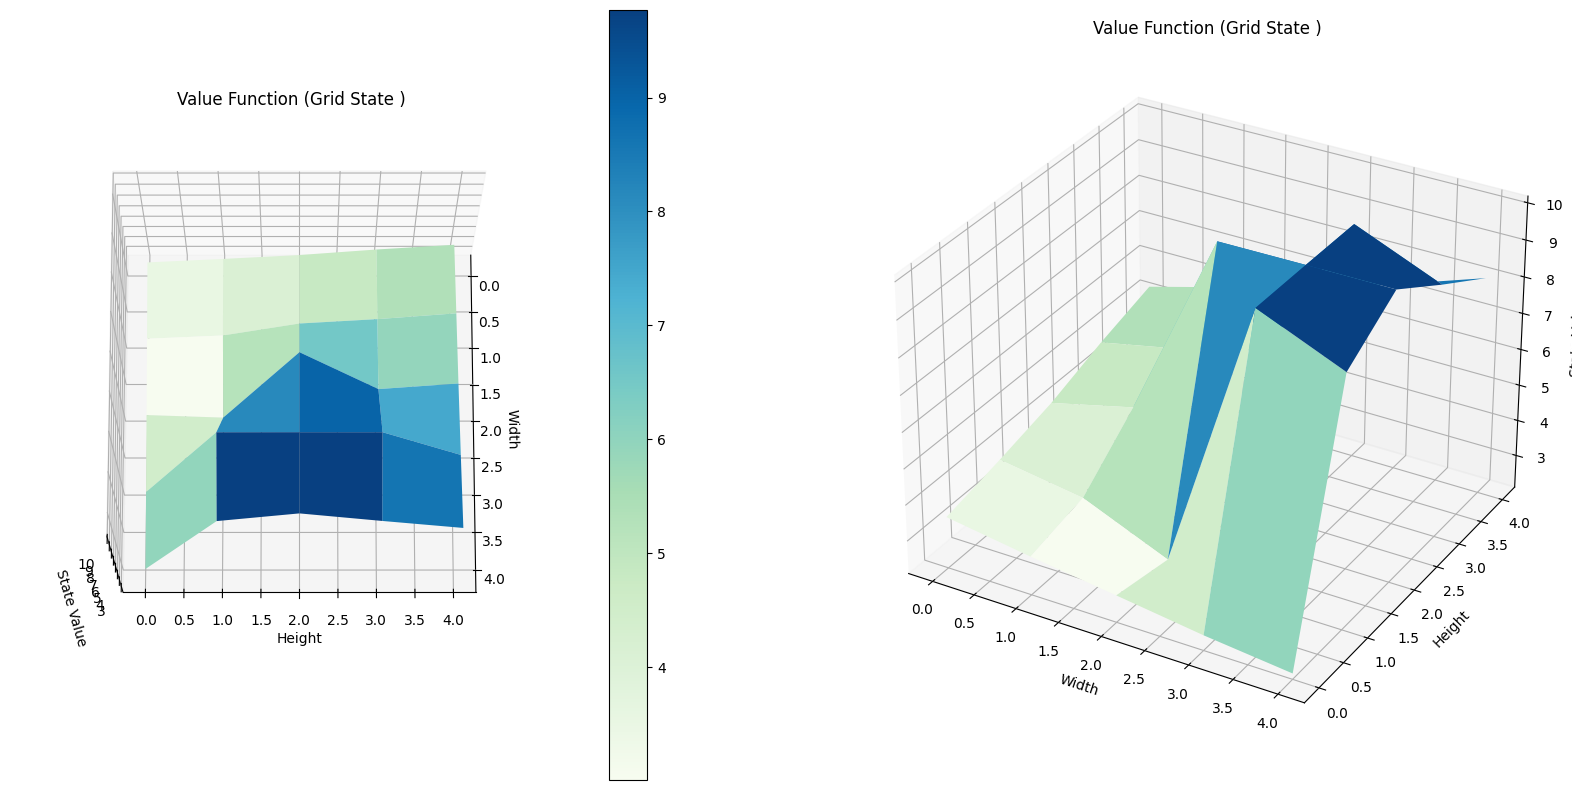

In [10]:
plot_value_function(V)
